# Análisis de Emisiones de CO₂ Globales

Este proyecto analiza datos históricos de emisiones de CO₂ a nivel mundial, explora relaciones entre factores económicos/demográficos y las emisiones, y realiza proyecciones futuras para los principales países emisores. Los datos provienen de Our World in Data (OWID).

_Objetivos:_
1. Identificar tendencias globales de emisiones (2000-2022)
2. Analizar correlaciones entre PIB/población y emisiones
3. Comparar evolución en países clave (China, EE.UU., Rusia)
4. Desarrollar modelos predictivos para emisiones futuras (2023-2035)

In [1]:
# Instalación de librerías
%pip install seaborn plotly statsmodels scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats

## 1. Carga y Preprocesamiento de Datos

In [3]:
# Cargar datos desde el repositorio de Our World in Data
url = "https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv"
df = pd.read_csv(url)
df.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1753,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1754,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Mostrar estructura inicial del dataset
print("Exploración inicial del dataset:")
print(f"- Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
print(f"- Años cubiertos: {df['year'].min()} - {df['year'].max()}")
print(f"- Países únicos: {df['country'].nunique()}")

Exploración inicial del dataset:
- Filas: 50191, Columnas: 79
- Años cubiertos: 1750 - 2023
- Países únicos: 255


In [5]:
# Limpieza y preparación de datos
# Seleccionar solo variables relevantes para el análisis
col_relevantes = ['country', 'year', 'co2', 'population', 'gdp']
df = df[col_relevantes]
df

,country,year,co2,population,gdp
0,Afghanistan,1750,NaN,2802560.0,NaN
1,Afghanistan,1751,NaN,NaN,NaN
2,Afghanistan,1752,NaN,NaN,NaN
3,Afghanistan,1753,NaN,NaN,NaN
4,Afghanistan,1754,NaN,NaN,NaN
...,...,...,...,...,...
50186,Zimbabwe,2019,10.263,15271377.0,2.514642e+10
50187,Zimbabwe,2020,8.495,15526888.0,2.317871e+10
50188,Zimbabwe,2021,10.204,15797220.0,2.514009e+10
50189,Zimbabwe,2022,10.425,16069061.0,2.590159e+10


In [6]:
# Filtrar datos a partir del año 2000
df = df[df['year'] >= 2000]
df

,country,year,co2,population,gdp
250,Afghanistan,2000,1.047,20130334.0,1.128379e+10
251,Afghanistan,2001,1.069,20284303.0,1.102127e+10
252,Afghanistan,2002,1.341,21378123.0,1.880487e+10
253,Afghanistan,2003,1.560,22733054.0,2.107434e+10
254,Afghanistan,2004,1.237,23560656.0,2.233257e+10
...,...,...,...,...,...
50186,Zimbabwe,2019,10.263,15271377.0,2.514642e+10
50187,Zimbabwe,2020,8.495,15526888.0,2.317871e+10
50188,Zimbabwe,2021,10.204,15797220.0,2.514009e+10
50189,Zimbabwe,2022,10.425,16069061.0,2.590159e+10


In [7]:
# Convertir GDP a billones de USD para mejor visualización
df['gdp_billones'] = df['gdp'] / 1e12
df.drop('gdp', axis=1, inplace=True) 
df

C:\Users\USER\AppData\Local\Temp\ipykernel_15748\1178855188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gdp_billones'] = df['gdp'] / 1e12
C:\Users\USER\AppData\Local\Temp\ipykernel_15748\1178855188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('gdp', axis=1, inplace=True)


,country,year,co2,population,gdp_billones
250,Afghanistan,2000,1.047,20130334.0,0.011284
251,Afghanistan,2001,1.069,20284303.0,0.011021
252,Afghanistan,2002,1.341,21378123.0,0.018805
253,Afghanistan,2003,1.560,22733054.0,0.021074
254,Afghanistan,2004,1.237,23560656.0,0.022333
...,...,...,...,...,...
50186,Zimbabwe,2019,10.263,15271377.0,0.025146
50187,Zimbabwe,2020,8.495,15526888.0,0.023179
50188,Zimbabwe,2021,10.204,15797220.0,0.025140
50189,Zimbabwe,2022,10.425,16069061.0,0.025902


In [8]:
# Eliminar filas con valores faltantes
print(f"- Registros iniciales: {len(df)}")
df.dropna(inplace=True)
print(f"- Registros después de limpiar valores faltantes: {len(df)}")

- Registros iniciales: 6120
- Registros después de limpiar valores faltantes: 3782


C:\Users\USER\AppData\Local\Temp\ipykernel_15748\3532756866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [9]:
# Eliminar entrada de 'World' para evitar duplicación en agregados
df = df[df['country'] != 'World']
df

,country,year,co2,population,gdp_billones
250,Afghanistan,2000,1.047,20130334.0,0.011284
251,Afghanistan,2001,1.069,20284303.0,0.011021
252,Afghanistan,2002,1.341,21378123.0,0.018805
253,Afghanistan,2003,1.560,22733054.0,0.021074
254,Afghanistan,2004,1.237,23560656.0,0.022333
...,...,...,...,...,...
50185,Zimbabwe,2018,11.205,15034457.0,0.026786
50186,Zimbabwe,2019,10.263,15271377.0,0.025146
50187,Zimbabwe,2020,8.495,15526888.0,0.023179
50188,Zimbabwe,2021,10.204,15797220.0,0.025140


In [10]:
# Reiniciar índice del DataFrame
df = df.reset_index(drop=True)
df

,country,year,co2,population,gdp_billones
0,Afghanistan,2000,1.047,20130334.0,0.011284
1,Afghanistan,2001,1.069,20284303.0,0.011021
2,Afghanistan,2002,1.341,21378123.0,0.018805
3,Afghanistan,2003,1.560,22733054.0,0.021074
4,Afghanistan,2004,1.237,23560656.0,0.022333
...,...,...,...,...,...
3767,Zimbabwe,2018,11.205,15034457.0,0.026786
3768,Zimbabwe,2019,10.263,15271377.0,0.025146
3769,Zimbabwe,2020,8.495,15526888.0,0.023179
3770,Zimbabwe,2021,10.204,15797220.0,0.025140


In [11]:
print("Estructura final del dataset:")
df.info()

Estructura final del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       3772 non-null   object 
 1   year          3772 non-null   int64  
 2   co2           3772 non-null   float64
 3   population    3772 non-null   float64
 4   gdp_billones  3772 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 147.5+ KB


## 2. Análisis Exploratorio de Datos (EDA)

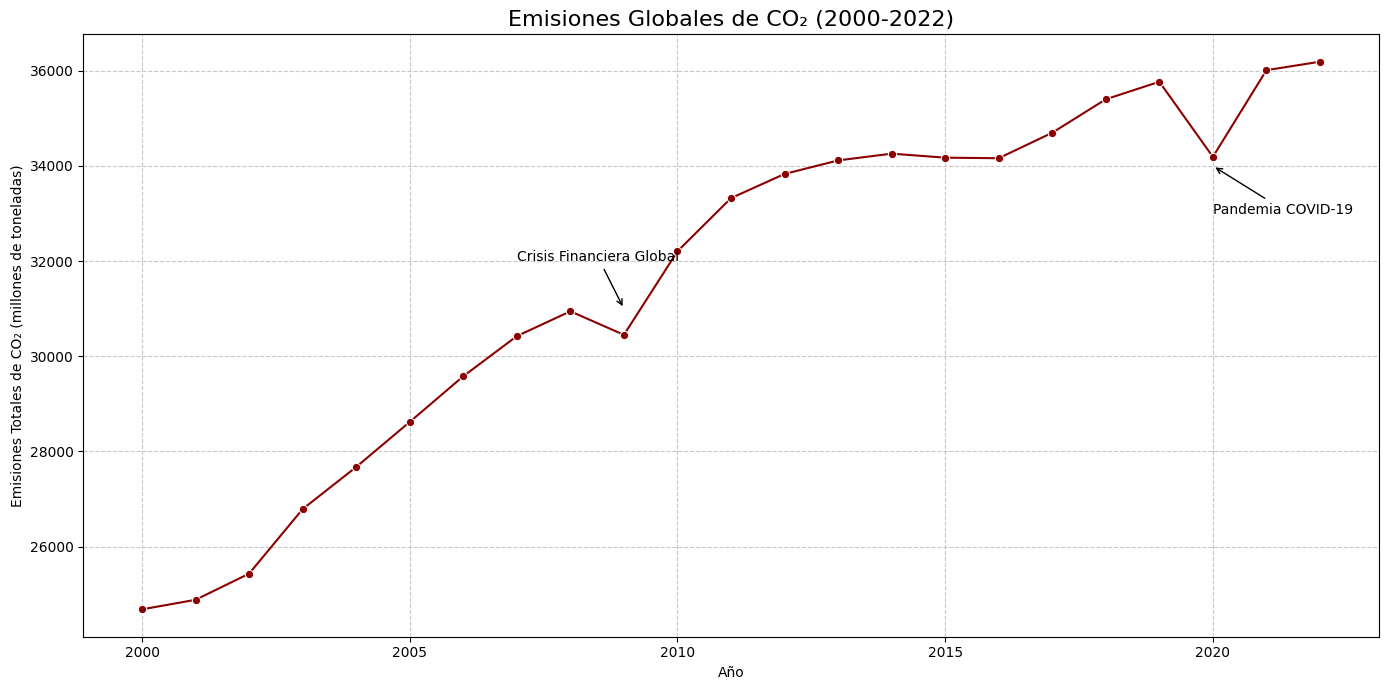

In [12]:
# Tendencia global de emisiones (2000-2022)

# Agrupar datos por año
emisiones_globales = df.groupby('year')['co2'].sum().reset_index()

# Crear visualización
plt.figure(figsize=(14, 7))
sns.lineplot(data=emisiones_globales, x='year', y='co2', marker='o', color='darkred')

# Personalizar gráfico
plt.title("Emisiones Globales de CO₂ (2000-2022)", fontsize=16)
plt.xlabel("Año")
plt.ylabel("Emisiones Totales de CO₂ (millones de toneladas)")
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir anotaciones importantes
plt.annotate('Crisis Financiera Global', xy=(2009, 31000), 
             xytext=(2007, 32000), arrowprops=dict(arrowstyle='->'))
plt.annotate('Pandemia COVID-19', xy=(2020, 34000), 
             xytext=(2020, 33000), arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.savefig('emisiones_globales.png', dpi=300)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_15748\359153635.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_emisores, x='co2', y='country', palette="viridis")


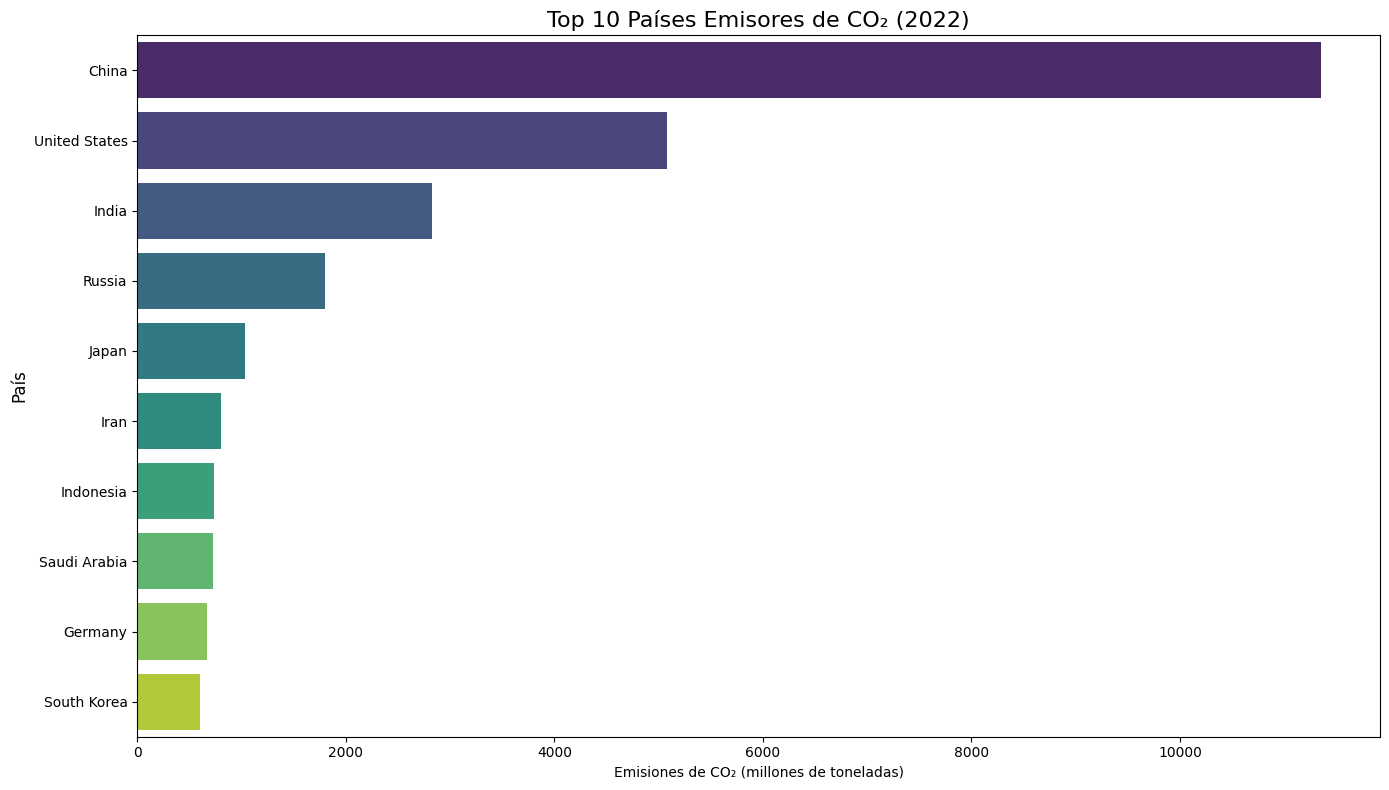

In [13]:
# Top 10 países emisores (último año)

# Obtener último año disponible
ultimo_anio = df['year'].max()
top_emisores = df[df['year'] == ultimo_anio].nlargest(10, 'co2')

# Crear visualización
plt.figure(figsize=(14, 8))
sns.barplot(data=top_emisores, x='co2', y='country', palette="viridis")

# Personalizar gráfico
plt.title(f"Top 10 Países Emisores de CO₂ ({ultimo_anio})", fontsize=16)
plt.xlabel("Emisiones de CO₂ (millones de toneladas)")
plt.ylabel("País", fontsize=12)

plt.tight_layout()
plt.savefig('top_emisores.png', dpi=300)
plt.show()

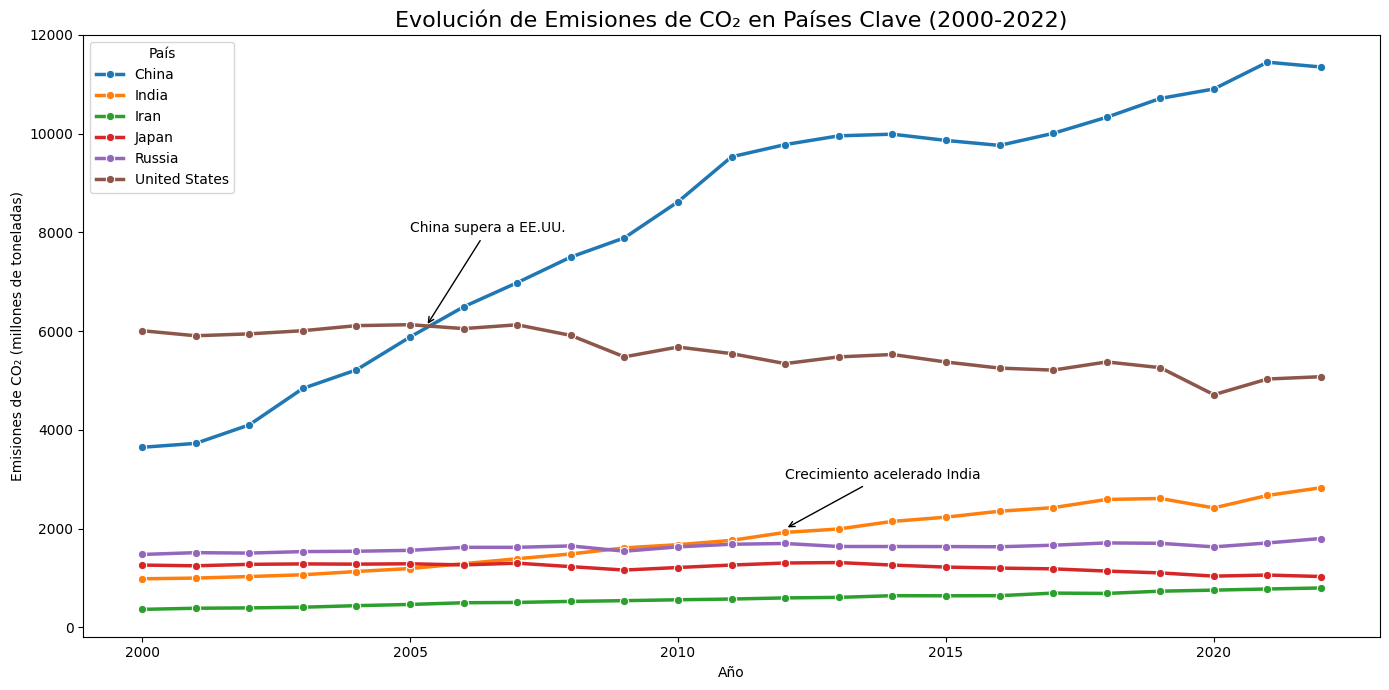

In [14]:
# Evolución en países clave

# Seleccionar países de interés
paises = ['China', 'United States', 'India', 'Russia', 'Japan', 'Iran']
df_paises = df[df['country'].isin(paises)]

# Crear visualización
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_paises, x='year', y='co2', hue='country', marker='o', linewidth=2.5)

# Personalizar gráfico
plt.title("Evolución de Emisiones de CO₂ en Países Clave (2000-2022)", fontsize=16)
plt.xlabel("Año")
plt.ylabel("Emisiones de CO₂ (millones de toneladas)")
plt.legend(title='País')

# Resaltar tendencias importantes
plt.annotate('China supera a EE.UU.', xy=(2005.3, 6100), 
             xytext=(2005, 8000), arrowprops=dict(arrowstyle='->'))
plt.annotate('Crecimiento acelerado India', xy=(2012, 2000), 
             xytext=(2012, 3000), arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.savefig('paises_clave.png', dpi=300)
plt.show()

## 3. Análisis de Correlaciones

In [15]:
# Relación entre desarrollo económico y emisiones
# Preparar datos para el último año disponible
data = df[df['year'] == ultimo_anio].dropna(subset=['gdp_billones', 'co2'])
data

,country,year,co2,population,gdp_billones
22,Afghanistan,2022,10.558,40578846.0,0.053303
45,Albania,2022,5.173,2827615.0,0.036171
68,Algeria,2022,184.558,45477391.0,0.595820
91,Angola,2022,20.250,35635028.0,0.158346
114,Argentina,2022,204.081,45407904.0,0.854914
...,...,...,...,...,...
3679,Venezuela,2022,87.515,28213016.0,0.149682
3702,Vietnam,2022,297.634,99680656.0,0.833804
3725,Yemen,2022,10.296,38222880.0,0.060853
3748,Zambia,2022,7.522,20152934.0,0.068470


In [16]:
# Calcular correlaciones para el último periodo
cor_pib = data[['gdp_billones', 'co2']].corr().iloc[0,1]
cor_poblacion = data[['population', 'co2']].corr().iloc[0,1]

print(f"- Correlación PIB-Emisiones ({ultimo_anio}): {cor_pib:.3f}")
print(f"- Correlación Población-Emisiones ({ultimo_anio}): {cor_poblacion:.3f}")

- Correlación PIB-Emisiones (2022): 0.967
- Correlación Población-Emisiones (2022): 0.816


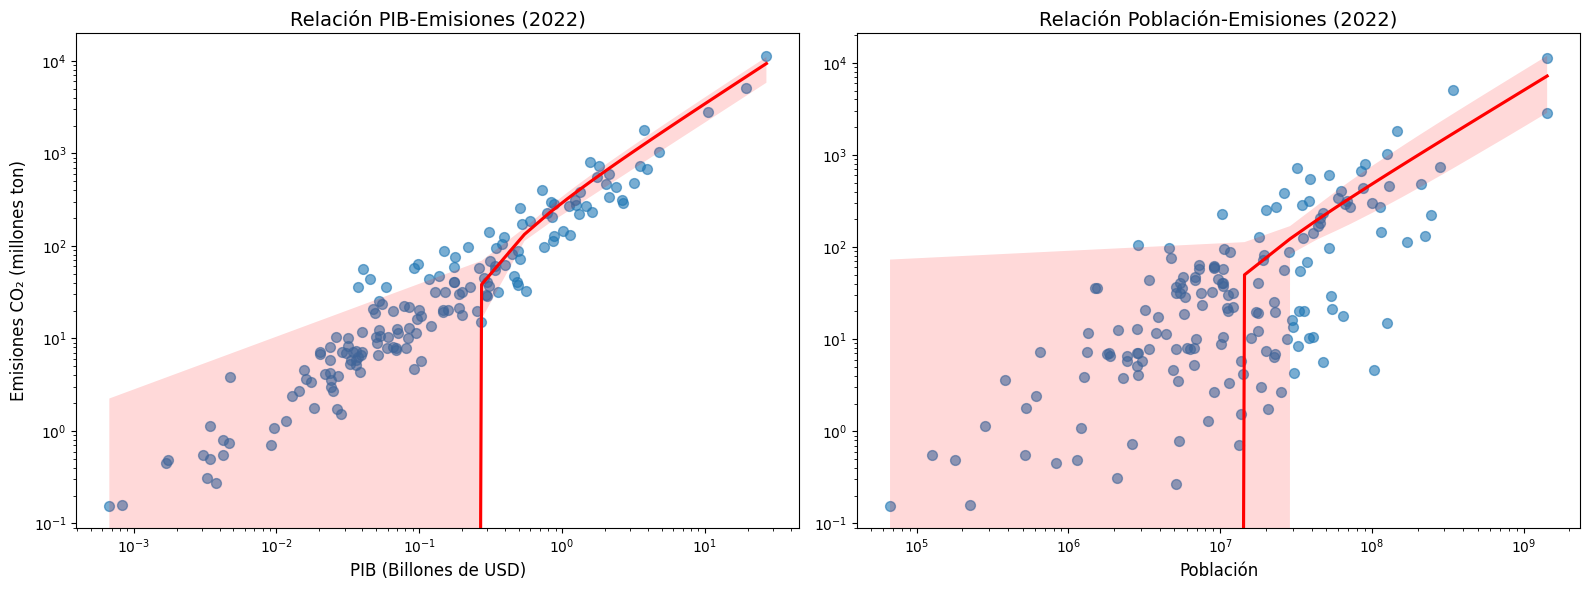

In [17]:
# Configurar el layout de subplots
plt.figure(figsize=(16, 6))

# Primer gráfico (PIB vs Emisiones)
plt.subplot(1, 2, 1)  
sns.regplot(data=data, x='gdp_billones', y='co2',
            scatter_kws={'s': 50, 'alpha':0.6}, 
            line_kws={'color':'red'})
plt.title(f"Relación PIB-Emisiones ({ultimo_anio})", fontsize=14)
plt.xlabel("PIB (Billones de USD)", fontsize=12)
plt.ylabel("Emisiones CO₂ (millones ton)", fontsize=12)
plt.xscale('log')
plt.yscale('log')

# Segundo gráfico (Población vs Emisiones)
plt.subplot(1, 2, 2)  
sns.regplot(data=data, x='population', y='co2', 
            scatter_kws={'s': 50, 'alpha':0.6}, 
            line_kws={'color':'red'})
plt.title(f"Relación Población-Emisiones ({ultimo_anio})", fontsize=14)
plt.xlabel("Población", fontsize=12)
plt.ylabel("")  
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.savefig('correlaciones.png', dpi=300)
plt.show()


In [18]:
# Calcular correlaciones para todo el período
correlacion_h_pib = df[['gdp_billones', 'co2']].corr().iloc[0, 1]
correlacion_h_pob = df[['population', 'co2']].corr().iloc[0, 1]

print("Correlaciones históricas (2000-2022)")
print(f"- Correlación PIB-Emisiones: {correlacion_h_pib:.3f}")
print(f"- Correlación Población-Emisiones: {correlacion_h_pob:.3f}")

Correlaciones históricas (2000-2022)
- Correlación PIB-Emisiones: 0.948
- Correlación Población-Emisiones: 0.760


## 4. Análisis Específico: China, EE.UU. y Rusia

In [19]:
# Análisis detallado de los 3 principales emisores
#Filtrar datos para los tres países
df_cur = df[df['country'].isin(['China', 'United States', 'Russia'])]
df_cur

,country,year,co2,population,gdp_billones
667,China,2000,3649.227,1.269581e+09,5.952683
668,China,2001,3728.510,1.278725e+09,6.329737
669,China,2002,4103.046,1.286867e+09,6.814494
670,China,2003,4841.119,1.294517e+09,7.248623
671,China,2004,5217.351,1.302100e+09,7.830953
...,...,...,...,...,...
3606,United States,2018,5377.797,3.350565e+08,18.124693
3607,United States,2019,5262.145,3.377901e+08,18.540552
3608,United States,2020,4714.628,3.394362e+08,18.027360
3609,United States,2021,5032.213,3.401614e+08,19.099378


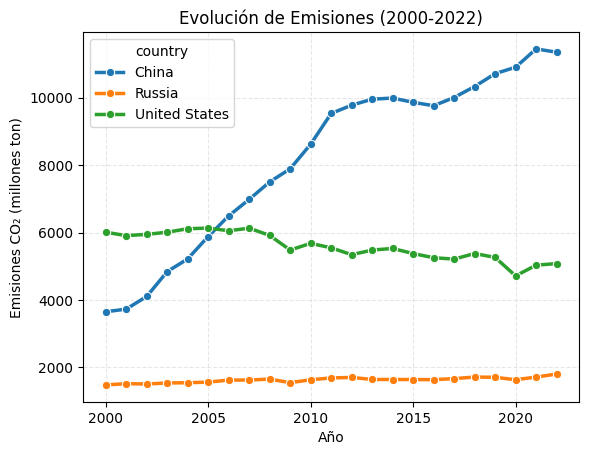

In [20]:
sns.lineplot(data=df_cur, x='year', y='co2', hue='country', 
             marker='o', linewidth=2.5)
plt.title("Evolución de Emisiones (2000-2022)")
plt.xlabel("Año")
plt.ylabel("Emisiones CO₂ (millones ton)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('evolucion_cur.png', dpi=300)

C:\Users\USER\AppData\Local\Temp\ipykernel_15748\381468640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=df_cur[df_cur['year'] == ultimo_anio],


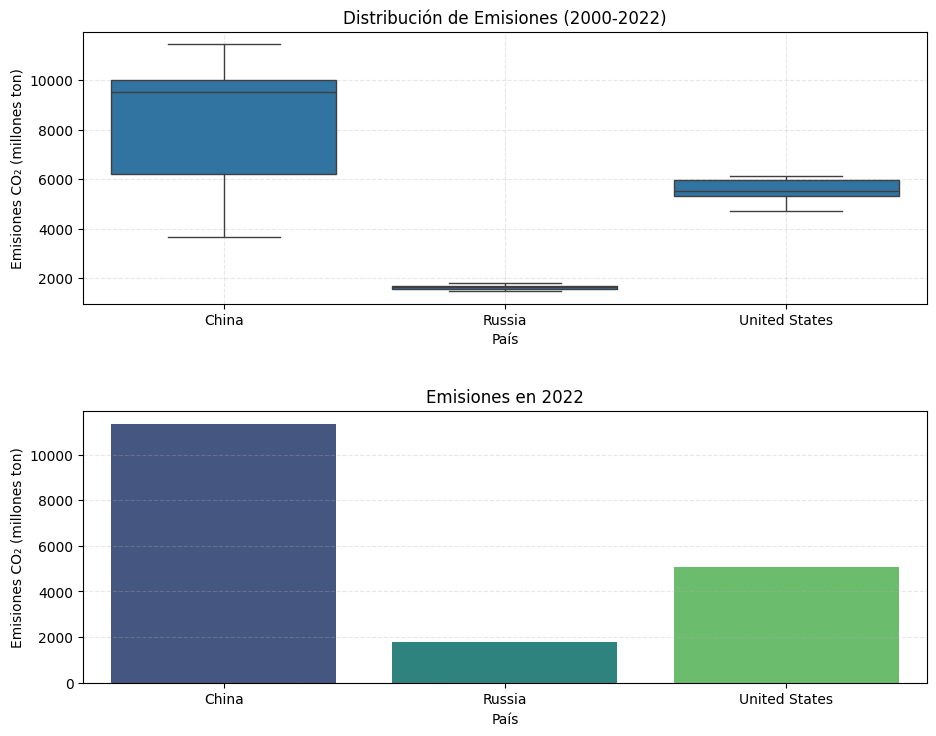

In [21]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)  
sns.boxplot(data=df_cur, x='country', y='co2')
plt.title("Distribución de Emisiones (2000-2022)")
plt.xlabel("País")
plt.ylabel("Emisiones CO₂ (millones ton)")  
plt.grid(True, linestyle='--', alpha=0.3)  

plt.subplot(2, 1, 2)  
bar_plot = sns.barplot(data=df_cur[df_cur['year'] == ultimo_anio], 
                       x='country', y='co2', palette="viridis")
plt.title(f"Emisiones en {ultimo_anio}")
plt.xlabel("País")
plt.ylabel("Emisiones CO₂ (millones ton)")  
plt.grid(True, linestyle='--', alpha=0.3, axis='y')  

plt.tight_layout(pad=3.0)  
plt.savefig('comparacion_emisores_cur.png', dpi=300)
plt.show()

## 5. Modelado Predictivo

In [22]:
# Función para crear y evaluar modelos predictivos
def crear_modelo_predictivo(pais, datos, color_historico, color_proyeccion):
    """
    Crea un modelo de regresión lineal para predecir emisiones futuras
    
    Parámetros:
    pais (str): Nombre del país a analizar
    datos (DataFrame): Dataset completo
    color_historico (str): Color para línea histórica
    color_proyeccion (str): Color para línea de proyección
    
    Retorna:
    tuple: (modelo, predicciones, r2, rmse)
    """
    print(f"Creando modelo predictivo para {pais}")

     # Preparar datos
    df_pais = datos[datos['country'] == pais][['year', 'co2']].set_index('year')
    df_pais = df_pais.sort_index()

    # Entrenar modelo
    X = df_pais.index.values.reshape(-1, 1)
    y = df_pais['co2'].values

    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    # Calcular métricas
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"- R²: {r2:.4f}")
    print(f"- RMSE: {rmse:.2f} millones de toneladas")

     # Generar proyecciones (2023-2035)
    anios_futuros = np.arange(2023, 2036).reshape(-1, 1)
    predicciones = modelo.predict(anios_futuros)

    # Visualizar resultados
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df_pais.index, y=df_pais['co2'], 
                 label=f'{pais} - Histórico', color=color_historico, linewidth=2.5)
    plt.plot(anios_futuros, predicciones, '--', 
             label=f'{pais} - Proyección', color=color_proyeccion, linewidth=2.5)
    
    plt.title(f"Proyección de Emisiones: {pais} (2023-2035)", fontsize=15)
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Emisiones CO₂ (millones ton)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{pais.lower()}_predicciones.png', dpi=300)
    plt.show()

    return modelo, predicciones, r2, rmse

Creando modelo predictivo para China
- R²: 0.9337
- RMSE: 648.27 millones de toneladas


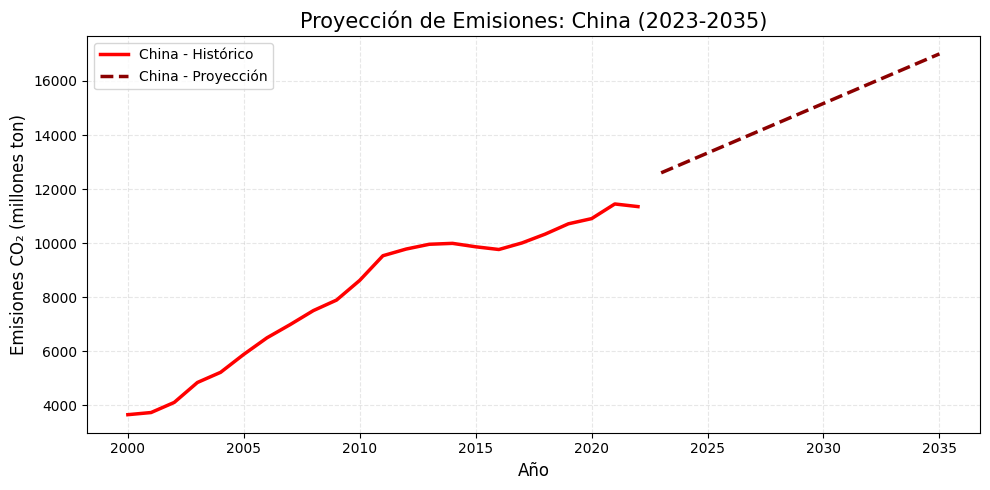

Creando modelo predictivo para United States
- R²: 0.8259
- RMSE: 166.22 millones de toneladas


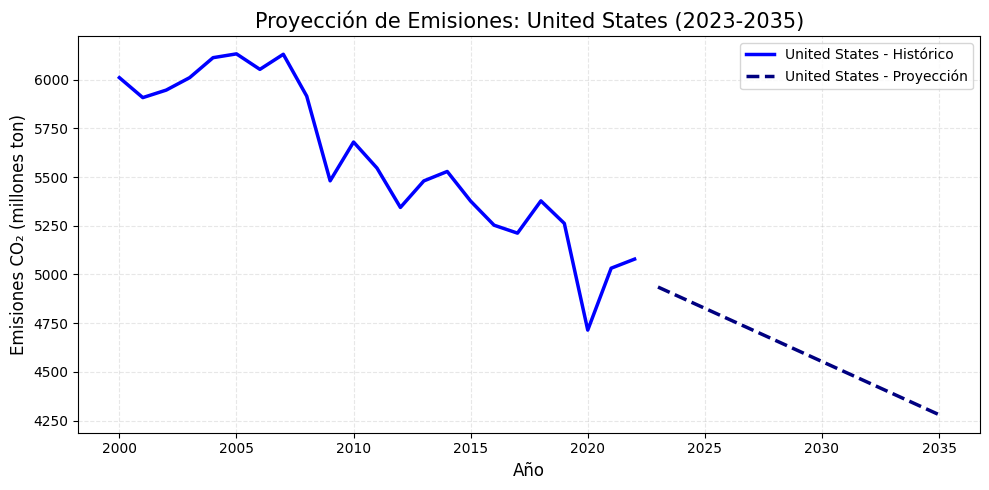

Creando modelo predictivo para Russia
- R²: 0.7381
- RMSE: 39.59 millones de toneladas


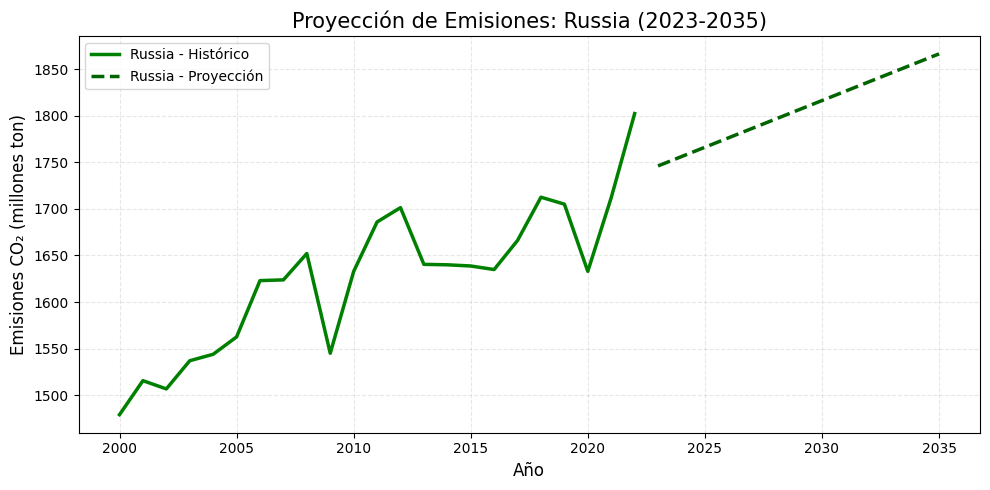

In [23]:
# Crear modelos para los 3 principales países
modelo_china, pred_china, r2_china, rmse_china = crear_modelo_predictivo(
    'China', df, 'red', 'darkred'
)
modelo_usa, pred_usa, r2_usa, rmse_usa = crear_modelo_predictivo(
    'United States', df, 'blue', 'navy'
)

modelo_rusia, pred_rusia, r2_rusia, rmse_rusia = crear_modelo_predictivo(
    'Russia', df, 'green', 'darkgreen'
)

Comparativa de proyecciones (2023-2035)


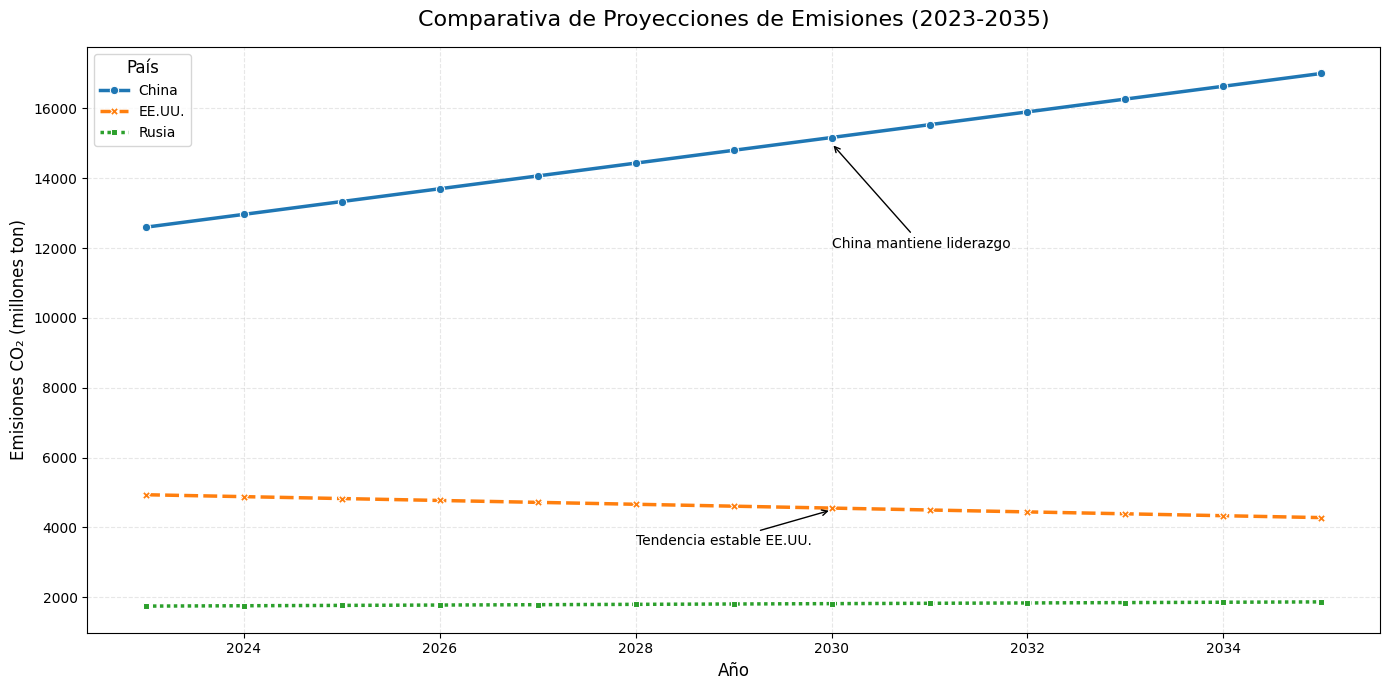

In [24]:
# Comparativa de proyecciones
print("Comparativa de proyecciones (2023-2035)")

# Preparar datos para visualización
anios_futuros = np.arange(2023, 2036)
df_proyecciones = pd.DataFrame({
    'Año': anios_futuros,
    'China': pred_china,
    'EE.UU.': pred_usa,
    'Rusia': pred_rusia
}).melt(id_vars='Año', var_name='País', value_name='Emisiones')

# Crear visualización comparativa
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_proyecciones, x='Año', y='Emisiones', 
             hue='País', style='País', markers=True, linewidth=2.5)

# Personalizar gráfico
plt.title("Comparativa de Proyecciones de Emisiones (2023-2035)", 
          fontsize=16, pad=15)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Emisiones CO₂ (millones ton)", fontsize=12)
plt.legend(title='País', title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Añadir anotaciones
plt.annotate('China mantiene liderazgo', xy=(2030, 15000), 
             xytext=(2030, 12000), arrowprops=dict(arrowstyle='->'))
plt.annotate('Tendencia estable EE.UU.', xy=(2030, 4500), 
             xytext=(2028, 3500), arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.savefig('proyeccion_comparativa.png', dpi=300)
plt.show()

## 6. Conclusiones y Recomendaciones

### _Conclusiones Clave_

1. Tendencias Globales: Las emisiones han mostrado un crecimiento constante, con caídas notables durante crisis económicas
2. Liderazgo Emisor: China es el principal emisor, superando a EE.UU. desde 2006
3. Correlaciones: Existe fuerte relación entre PIB y emisiones (r=0.948), menor con población (r=0.760)
4. Proyecciones: China mantendrá su liderazgo emisor, con EE.UU. y Rusia mostrando tendencias estables

### _Recomendaciones_

- Implementar políticas de descarbonización en sectores industriales
- Promover tecnologías de captura de carbono en grandes emisores

In [25]:
# Crear resumen métrico de modelos
resumen = pd.DataFrame({
    'País': ['China', 'EE.UU.', 'Rusia'],
    'R²': [r2_china, r2_usa, r2_rusia],
    'RMSE': [rmse_china, rmse_usa, rmse_rusia],
    'Emisiones 2035 (proyectado)': [pred_china[-1], pred_usa[-1], pred_rusia[-1]]
})
print("Resumen de Modelos Predictivos:")
display(resumen)

Resumen de Modelos Predictivos:


,País,R²,RMSE,Emisiones 2035 (proyectado)
0,China,0.933744,648.267763,17003.239055
1,EE.UU.,0.825945,166.219441,4280.515423
2,Rusia,0.738057,39.592665,1866.271308
